##### Package imports

In [2]:
import xarray as xr
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# key definitions are in a separte file
from WeatherTyping import loop_kmeans, get_number_eof, get_classifiability_index

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

##### Create the necessary directories

In [3]:
!mkdir -p data

##### Download Data
Go on the given URLs for model and reanalysis data:
model_url=https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(26%20Apr%202018)/VALUE/X/(-170)/(-30)/RANGE/Y/(20)/(80)/RANGE/hdate/(1998)/(2017)/RANGE/L/5/runningAverage/dup/%5Bhdate/M%5D/average/sub/S/removeGRID/data.nc
reanalysis_url=https://iridl.ldeo.columbia.edu/auth/login?ver=1&redirect=%2FSOURCES%2F.ECMWF%2F.S2S%2F.ECMF%2F.reforecast%2F.perturbed%2F.pressure_level_gh%2F.gh%2FP%2F500%2FVALUE%2FP%2FremoveGRID%2FS%2F%2826%20Apr%202018%29%2FVALUE%2FX%2F%28-170%29%2F%28-30%29%2FRANGE%2FY%2F%2820%29%2F%2880%29%2FRANGE%2Fhdate%2F%281998%29%2F%282017%29%2FRANGE%2Fhdate%2F%2Fpointwidth%2F0%2Fdef%2F-6%2FshiftGRID%2Fhdate%2F%28days%20since%201960-01-01%29%2Fstreamgridunitconvert%2FS%2F%28days%20since%202018-01-01%29%2Fstreamgridunitconvert%2FS%2F%2Funits%2F%2Fdays%2Fdef%2FL%2F0.5%2Fadd%2Fhdate%2Fadd%2Fadd%2F%2Fpointwidth%2F1%2Fdef%2FSOURCES%2F.ECMWF%2F.ERA-Interim%2F.SIX-HOURLY%2F.pressure_level%2F.z500%2FT%2F3%2FshiftGRID%2FT%2F24%2FboxAverage%2FT%2F2%2Findex%2F.units%2Fstreamgridunitconvert%2Fexch%2F%5BT%5Dsample-along%2Fc%3A%2F9.81%2F%28m%20s-2%29%2F%3Ac%2Fdiv%2FS%2FremoveGRID%2FL%2F5%2FrunningAverage%2F%5BX%2FY%5D%2F1.0%2F0.%2FregridLinear%2Fdup%2F%5Bhdate%5Daverage%2F2%2FRECHUNK%2Fsub%2Fdata.nc&realm=iri.columbia.edu%2Fterms%2Fs2s%2F1

Follow instructions for a double login.

Login IRI username: pr2616@columbia.edu 

Login IRI password: Patric1234

Save the data into the folder with name 'data' which we created just above.



In [4]:
ds = xr.open_dataset('/home/jovyan/rces-assignments/WeatherTyping/data/data11.nc', decode_times=False)
model = ds.stack(time=['hdate', 'L'], grid=['X', 'Y'])
model

<xarray.Dataset>
Dimensions:  (M: 10, grid: 3990, time: 860)
Coordinates:
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * time     (time) MultiIndex
  - hdate    (time) float64 462.0 462.0 462.0 462.0 ... 690.0 690.0 690.0 690.0
  - L        (time) float64 2.0 3.0 4.0 5.0 6.0 7.0 ... 40.0 41.0 42.0 43.0 44.0
  * grid     (grid) MultiIndex
  - X        (grid) float64 -171.0 -171.0 -171.0 -171.0 ... -30.0 -30.0 -30.0
  - Y        (grid) float64 19.5 21.0 22.5 24.0 25.5 ... 76.5 78.0 79.5 81.0
Data variables:
    gh       (M, time, grid) float64 7.766 1.977 -0.7635 ... 137.3 139.7 136.6

In [5]:
reanalysis = xr.open_dataset('/home/jovyan/rces-assignments/WeatherTyping/data/data10.nc', decode_times=False)
reanalysis = reanalysis.stack(time=['hdate', 'L'], grid=['X', 'Y'])
reanalysis

<xarray.Dataset>
Dimensions:  (grid: 3990, time: 860)
Coordinates:
  * time     (time) MultiIndex
  - hdate    (time) float64 1.388e+04 1.388e+04 ... 2.082e+04 2.082e+04
  - L        (time) float64 2.0 3.0 4.0 5.0 6.0 7.0 ... 40.0 41.0 42.0 43.0 44.0
  * grid     (grid) MultiIndex
  - X        (grid) float64 -171.0 -171.0 -171.0 -171.0 ... -30.0 -30.0 -30.0
  - Y        (grid) float64 19.5 21.0 22.5 24.0 25.5 ... 76.5 78.0 79.5 81.0
Data variables:
    ratio    (time, grid) float64 9.606 10.93 14.4 ... -300.6 -306.1 -311.4

## Exploratory Analysis

In [11]:
reanalysis['ratio']
x=reanalysis['ratio'].X
y=reanalysis['ratio'].Y
time = reanalysis['ratio'].time

In [7]:
#x=reanalysis['ratio'].values
#x

In [24]:
#fig, ax = plt.subplots(figsize=(12,4))
#p = ax.pcolormesh(x, time, reanalysis['ratio'])
#fig.colorbar(p, ax=ax)

In [10]:
xx,yy = np.meshgrid(x,y)
yy.shape
xx.shape
x.shape
y.shape
time.shape
#plt.pcolormesh(x,time,reanalysis['ratio'])

(860,)

## Reducing Dimensions

In the following, we will reduce our datasize which is strongly spacially corrolated to just a few EOFs. 
The number of EOFs can be chosen based on how much variance of the data we want to explain with our EOFs. 


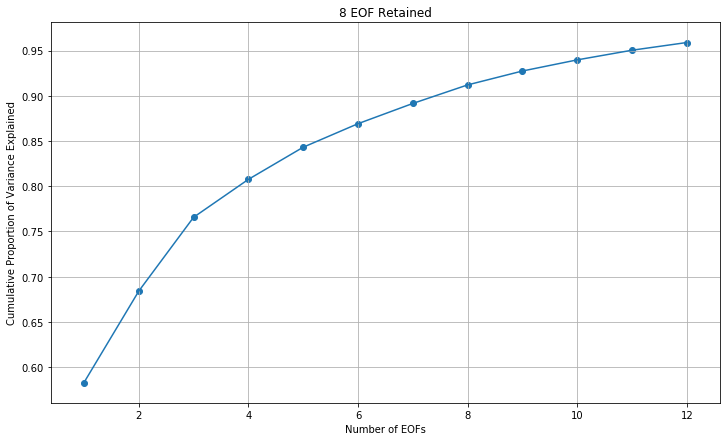

In [19]:
n_eof = get_number_eof(X=reanalysis['ratio'].values, var_to_explain=0.9, plot=True) #here, we chose to represent 90% of the variance.

In [ ]:
#PCA?

Now we project the data onto the leading EOFs to get the principal component time series.
We will retain the PCA model for use later.
The `reanalysis_pc` variable is now indexed [`time`, `EOF`].

In [20]:
pca_model = PCA(n_components=n_eof).fit(reanalysis['ratio'].values)
reanalysis_pc = pca_model.transform(reanalysis['ratio'].values)

## Reanalysis Weather Typing

Now we perform the clustering.
We will manually specify the number of clusters we want to create and the number of simulations we want to run.

In [21]:
ncluster = 4 # use 4 WTs
n_sim = 25 # typically several hundred -- this is for quick preliminary computation only

Now we can use this to run the classifiability index on our centroids

In [23]:
centroids, wtypes = loop_kmeans(X=reanalysis_pc, n_cluster=ncluster, n_sim=n_sim)
class_idx, best_part = get_classifiability_index(centroids)
print('The classifiability index is {}'.format(class_idx))

The classifiability index is 0.9971768076194542


Now that we have identified a suitable partition, we can use it to keep only the corresponding centroid and set of weather type labels.
To take advantage of the scikit-learn syntax, we then use these centroids to define a `KMeans` object.

In [26]:
best_fit = KMeans(n_clusters=ncluster, init=centroids[best_part, :, :], n_init=1, max_iter=1).fit(reanalysis_pc)

## Model Weather Types

Now, for each ensemble member, calculate the weather types by projecting the model geopotential height anomaly fields onto the reanalysis regimes and assigning each day of the forecast to the closest centroid in terms of Euclidean distance. The model anomaly fields are first calculated by first taking 5-day running averages and then subtracting the hindcast climatology on a daily basis. The anomalies are then projected into the reanalysis EOFs, and the distances then calculated in EOF space.

In [27]:
# start with reanalysis
reanalysis_composite = reanalysis.copy()
model_clust = best_fit.fit_predict(reanalysis_pc) # get centroids
weather_types = xr.DataArray(
    model_clust, 
    coords = {'time': reanalysis_composite['time']},
    dims='time'
)
reanalysis_composite['WT'] = weather_types
reanalysis_composite = reanalysis_composite.groupby('WT').mean(dim='time').unstack('grid')['ratio']
reanalysis_composite['M'] = 0

In [28]:
wt_anomalies = [] # initialize empty list
wt_anomalies.append(reanalysis_composite)
# loop through each model member
for m in model['M'].values:
    member_data = model['gh'].sel(M=m) # get subset of data
    member_pc_ts = pca_model.transform(member_data.values) # project leading EOFs onto reanalysis EOFs
    member_clust = best_fit.predict(member_pc_ts) # assign to nearest cluster (computed on reanalysis)
    member_clust = weather_types = xr.DataArray(
        model_clust, 
        coords = {'time': model['time']},
        dims='time'
    )
    member_data = member_data.unstack('grid') #
    member_data['WT'] = member_clust
    member_data = member_data.groupby('WT').mean(dim='time')
    wt_anomalies.append(member_data)
wt_anomalies = xr.concat(wt_anomalies, dim='M') # join together
wt_anomalies['WT'] = wt_anomalies['WT'] + 1 # start from 1

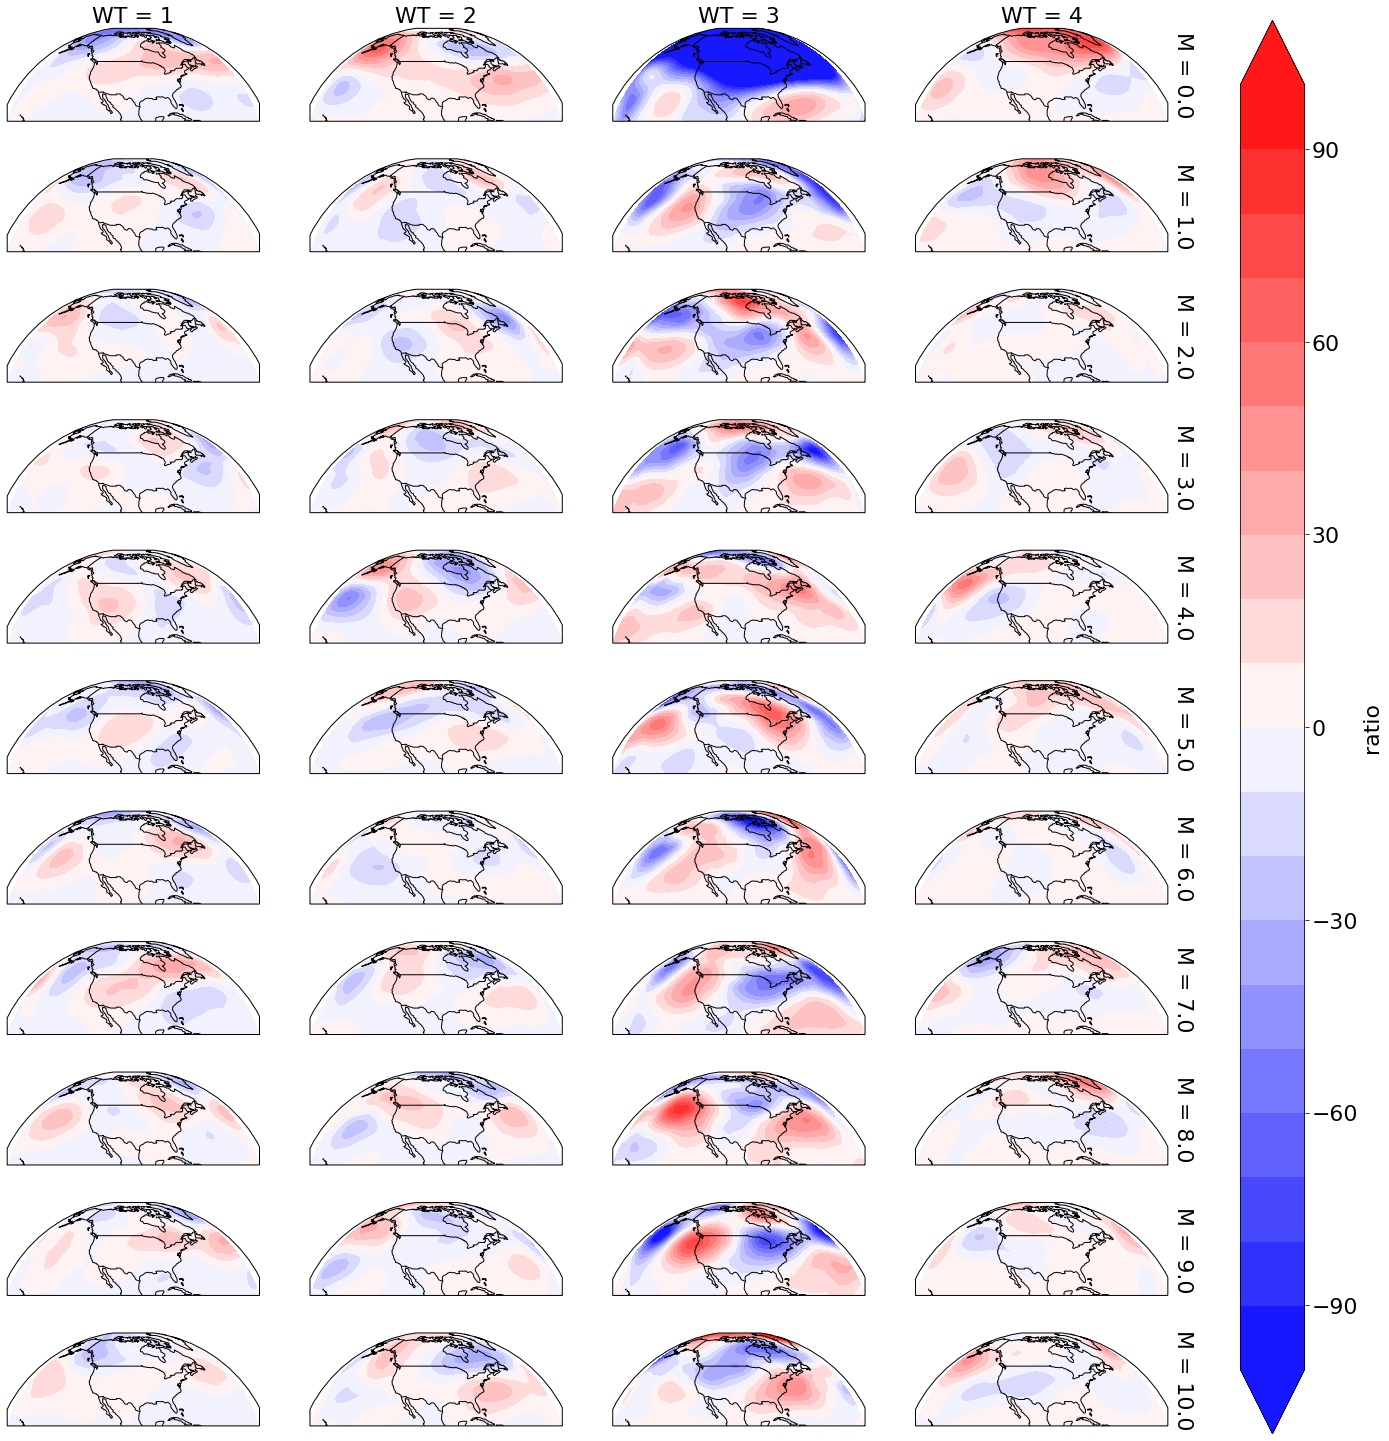

In [30]:
plt.rcParams.update({'font.size': 22})

p = wt_anomalies.plot.contourf(
    x='X', y='Y', col='WT', row='M',
    transform=ccrs.PlateCarree(),
    subplot_kws={
        'projection': ccrs.Orthographic(-100, 0)
        #ccrs.PlateCarree()
    },
    figsize=(26, 26),
    levels = np.linspace(-100, 100, 21),
    cmap=plt.cm.bwr,
    extend='both'
)

xmin,xmax = wt_anomalies['X'].min(), wt_anomalies['X'].max()
ymin,ymax = wt_anomalies['Y'].min(), wt_anomalies['Y'].max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    ax.set_extent([xmin, xmax, ymin, ymax])

plt.show()